In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import matplotlib
import seaborn as sns 
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv(r"movies_data_phase_2_completed.csv")

In [3]:
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------

In [4]:
#  Data Transformation

In [5]:
## Normalization

for col in list(data.columns) :
    if data[col].dtype != "object" :
        data[col] = ( data[col] - np.min(data[col]) ) / ( np.max(data[col]) - np.min(data[col]) ) 



In [6]:
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer with Yeo-Johnson method
pt = PowerTransformer(method='yeo-johnson')

# Fit the transformer on numeric columns
numeric_data = data.select_dtypes(exclude=['object'])

pt.fit(numeric_data)

# Transform all numeric columns at once
transformed_numeric_data = pt.transform(numeric_data)

# Assign transformed data back to the DataFrame
data[numeric_data.columns] = transformed_numeric_data


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [7]:
## Standardization

for col in list(data.columns) :
    if data[col].dtype != "object" :
        data[col] = ( data[col] - np.mean(data[col]) ) / np.std(data[col])

In [8]:
# Rechecking for the statistics :


for i in list(data.loc[:: , ["score" , "votes" ,"runtime", "budget" , "gross" , "profit" ,"return_on_investment_percent" ,"profit_margin_percent" ]].columns) :
    c = data[i]
    print( f"the column name : {i} \n mean : {np.mean(c)} \n median :{np.median(c)} \n range : {np.max(c) - np.min(c) } \n std : {np.std(c)} \n the variation : {np.var(c)} \n the Skewness : {c.skew()}" ,end= '\n\n\n')

the column name : score 
 mean : 5.1817154841210587e-17 
 median :0.014450052663656074 
 range : 6.011994221160472 
 std : 1.0 
 the variation : 1.0 
 the Skewness : -0.02824505127771698


the column name : votes 
 mean : 0.0 
 median :-0.1996733362884788 
 range : 3.3461070826972144 
 std : 1.0 
 the variation : 1.0000000000000002 
 the Skewness : 0.49079523839682093


the column name : runtime 
 mean : 0.0 
 median :-0.054771030062337814 
 range : 5.859197109264537 
 std : 1.0 
 the variation : 1.0000000000000002 
 the Skewness : 0.010697837291540547


the column name : budget 
 mean : 0.0 
 median :0.30152952306445924 
 range : 5.260513099566462 
 std : 1.0 
 the variation : 1.0000000000000002 
 the Skewness : 0.01208890902443228


the column name : gross 
 mean : -5.1817154841210587e-17 
 median :-0.21959843033440823 
 range : 3.0680852824932314 
 std : 1.0 
 the variation : 1.0000000000000002 
 the Skewness : 0.39674127392718495


the column name : profit 
 mean : -1.7272384947070

In [9]:
data.shape

(6582, 19)

In [10]:
# rechecking for outliers

for col in list(data.columns) :
    if data[col].dtype != "object" :
        z_score = ( data[col] - np.mean(data[col]) )/np.std(data[col])
        data["z_score"] = z_score
        data=data[ (data["z_score"] < 4) & (data["z_score"] > -4) ]
        data.drop(["z_score"] , axis=1 , inplace=True)


In [11]:
data.shape

(6307, 19)

In [12]:
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------

In [13]:
# Data Splitting

In [14]:
 
# We have to split the data first so we can continue to the encoding preocess

from sklearn.model_selection import train_test_split

x = data.drop("score_category" , axis=1)
y = data["score_category"]

x_train , x_test , y_train , y_test = train_test_split(x,y , train_size=0.85 , shuffle=True , random_state=42 , stratify =y)



In [15]:
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------

In [16]:
# Encoding Categorical Variables

In [17]:
y.head(5)

0    Medium
2    Medium
4    Medium
5      High
6    Medium
Name: score_category, dtype: object

In [18]:
data.nunique()

name                            6197
rating                            11
genre                             17
year                              41
released                        3020
score                             61
votes                            673
director                        2683
writer                          4033
star                            2498
country                           56
budget                           309
gross                           6164
company                         2107
runtime                           74
profit                          6182
return_on_investment_percent     867
profit_margin_percent           1695
score_category                     3
dtype: int64

In [19]:
## Encoding training data 

## Count Encoding
count_encoding_columns = ["name" , "rating" , "genre" ,"released"]
for col in count_encoding_columns :
    col_freq = x_train[col].value_counts().to_dict()
    x_train[col] = x_train[col].map(col_freq)
    x_test[col] = x_test[col].map(col_freq).fillna(0)

    min = np.min(x_train[col])
    max= np.max(x_train[col])
    # Scale the training data
    x_train[col] = (x_train[col] -  min) / ( max - min)
    # Use min and max of training data to scale the test data to avoid data leakage
    x_test[col] = (x_test[col] - min ) / ( max - min)




### Ordinal Encoding : Manually 
score_cat_mapping = { "Low" : 0 , "Medium" : 1 , "High" : 2  }
y_train = y_train.map(score_cat_mapping)
y_test = y_test.map(score_cat_mapping)





### Target Encoding
target_encoding_columns = ["director" , "writer", "star" , "country" ,"company"]
from category_encoders import TargetEncoder
encoder = TargetEncoder(smoothing=3 , 
                        min_samples_leaf=10 , 
                        return_df=True  , 
                        handle_missing = "value" , 
                        handle_unknown="value" , cols=target_encoding_columns )

x_train = encoder.fit_transform(x_train , y_train)
x_test = encoder.transform(x_test)


In [20]:
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------

In [21]:
# Final Data Check 


In [22]:
x_train

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,return_on_investment_percent,profit_margin_percent
4817,0.0,1.000000,0.611111,0.761732,0.000,0.742720,-0.457987,0.944216,0.942782,0.941708,0.948528,0.589608,-0.983820,0.941708,0.524179,-1.227518,-0.578336,0.053562
5539,0.0,0.493405,1.000000,1.174759,0.250,0.490536,1.914083,0.916754,0.941708,0.944216,0.917104,0.560534,1.634614,0.928572,-0.372892,1.653551,0.429955,0.350870
1856,0.0,1.000000,1.000000,-0.761120,0.375,0.872425,-0.619824,0.987234,0.983542,0.944216,1.049995,0.589608,-1.089658,0.934203,0.658279,-1.299340,-0.591692,-0.195590
153,0.5,1.000000,0.128472,-1.664090,0.125,-0.631641,-1.146170,0.942782,0.941708,0.941708,0.962233,0.589608,-0.843403,0.941708,-0.891836,-1.129728,-0.558348,0.171379
6357,0.0,1.000000,0.181134,1.574830,0.000,0.615431,-0.234750,0.868534,0.941708,1.027417,1.010471,0.589608,-0.910020,0.969403,0.788513,-1.176488,-0.568335,0.128681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,0.0,0.493405,0.611111,-0.199967,0.250,-0.425111,1.132445,0.983542,0.942782,0.964350,0.917104,2.828078,1.838409,0.932489,0.386028,1.389475,-0.110143,0.341073
2288,0.0,0.306239,1.000000,-0.570817,0.500,-2.058139,-0.870223,0.910297,0.910297,0.869114,0.917104,-0.706976,0.669891,0.916754,-0.455748,0.742843,0.304898,0.349750
2283,0.0,1.000000,0.233218,-0.476918,0.375,-0.529462,-1.061034,0.941708,0.941708,0.990278,0.917104,-1.011422,-0.119476,0.951572,1.331143,0.280331,-0.023215,0.343870
43,0.5,1.000000,0.611111,-1.876630,0.250,-1.110748,-1.080844,0.964350,0.885282,0.992705,0.917104,-0.164882,-0.239802,0.932489,0.455622,-0.167027,-0.374382,0.320134


In [23]:
x_test

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,return_on_investment_percent,profit_margin_percent
3463,-0.5,1.000000,0.630208,0.158968,-0.125,0.742720,0.234953,0.992705,0.938806,0.974456,0.917104,-1.011422,-1.207247,0.938806,-0.132374,-0.290662,-0.605072,-1.245938
3230,-0.5,1.000000,0.181134,0.070286,0.375,1.415851,1.244095,0.942782,0.938806,0.946100,0.917104,-1.699543,-0.459284,0.999999,1.038067,0.316911,1.092764,0.354514
2976,-0.5,0.306239,0.630208,-0.109164,0.250,1.004569,-0.306684,0.955264,0.974456,0.999207,0.917104,-1.011422,-0.570580,0.941708,0.524179,0.024367,-0.293746,0.330175
1843,-0.5,1.000000,1.000000,-0.761120,0.375,-0.631641,-1.065974,0.938806,0.938806,0.938806,0.917104,0.589608,-0.912528,0.938806,-0.983701,-1.178236,-0.568335,0.126797
1107,-0.5,0.306239,0.176505,-1.152444,0.250,-0.209807,-1.016957,0.938806,0.938806,0.987234,0.917104,0.589608,-1.195549,0.935323,-1.077219,-1.369670,-0.605072,-2.153330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,-0.5,1.000000,1.000000,0.421035,0.250,1.557970,0.873924,0.938806,0.938806,0.938806,1.010471,0.589608,-0.629530,0.941708,-0.801577,-0.974835,-0.528467,0.244297
645,-0.5,0.306239,1.000000,-1.353911,0.250,-0.098809,-0.578335,0.951572,0.938806,0.955264,0.917104,0.589608,0.155907,0.962085,-1.368169,-0.328134,-0.380872,0.319020
3051,-0.5,1.000000,0.233218,-0.109164,-0.125,-0.425111,1.019298,0.974456,0.948528,0.880394,0.917104,1.957416,1.555326,0.962085,-0.372892,0.834266,-0.147736,0.339674
6090,-0.5,0.493405,0.087384,1.416275,-0.125,0.490536,-0.343563,0.938806,0.938806,0.938806,1.178571,0.589608,-0.810675,0.938806,0.524179,-1.106505,-0.555022,0.187410


In [24]:
y_train.value_counts()

score_category
1    4858
0     415
2      87
Name: count, dtype: int64

In [25]:
y_test.value_counts()

score_category
1    858
0     73
2     16
Name: count, dtype: int64

### Testing some stuff

In [40]:
# saving_data = pd.concat( [ pd.concat([x_train , x_test] , axis=0) , pd.concat([y_train , y_test] , axis=0) ] , axis=1)

# saving_data


# saving_data.to_csv("movies_data_phase_3_completed.csv" , index=False)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=5 , shuffle=True , random_state=42)

In [29]:
models = {
"logastic_regression" : np.mean(cross_val_score(LogisticRegression(max_iter = 3000 , random_state = 42) , x_train , y_train , cv=skf ,  scoring="accuracy" )) ,
"Perceptron" : np.mean(cross_val_score(Perceptron(max_iter=3000 ,eta0=0.001 , shuffle=True , random_state=42 , early_stopping=True) , x_train , y_train , cv=skf ,  scoring="accuracy" ))
    
}

for key , val in models.items() :
    print("{:s} --> {:.3f}".format(key , val))

logastic_regression --> 0.996
Perceptron --> 0.975


In [30]:



model= LogisticRegression(max_iter = 3000 , random_state = 42)

model.fit(x_train , y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [31]:
print(model.coef_ , model.intercept_ , sep="\n\n" )

[[ 2.71123454e-01  3.64683394e-01  2.37335329e-01  6.52144348e-02
  -3.52769437e-01 -9.52172009e+00 -2.18829905e-02 -1.40905534e+00
  -1.55863683e+00 -1.37868768e+00 -5.55905301e-03  6.89139807e-02
  -3.29890109e-02 -9.67254096e-01 -1.49944109e-01  6.76334877e-02
  -1.07622933e-01 -3.24354917e-02]
 [-6.14568920e-02 -2.98945485e-02  3.41207993e-01  3.03185084e-02
  -1.30574864e-01  1.39595076e+00 -7.46179726e-02  7.54158641e-01
   7.86940926e-01  4.73254189e-01 -5.87667970e-01 -1.47331892e-01
   3.01976550e-01  1.24921113e-01 -3.29918663e-02  3.44527823e-03
  -1.94099187e-01 -8.75489186e-02]
 [-2.09666562e-01 -3.34788846e-01 -5.78543322e-01 -9.55329432e-02
   4.83344301e-01  8.12576933e+00  9.65009631e-02  6.54896700e-01
   7.71695900e-01  9.05433495e-01  5.93227023e-01  7.84179112e-02
  -2.68987539e-01  8.42332984e-01  1.82935976e-01 -7.10787659e-02
   3.01722120e-01  1.19984410e-01]]

[-0.89089968  8.62330309 -7.73240341]


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [33]:
y_train_pred = model.predict(x_train)

train_accuracy = accuracy_score(y_train , y_train_pred)

print(train_accuracy)

0.998320895522388


In [34]:
y_test_pred = model.predict(x_test)

test_accuracy = accuracy_score(y_test , y_test_pred)

print(test_accuracy)

0.9915522703273495


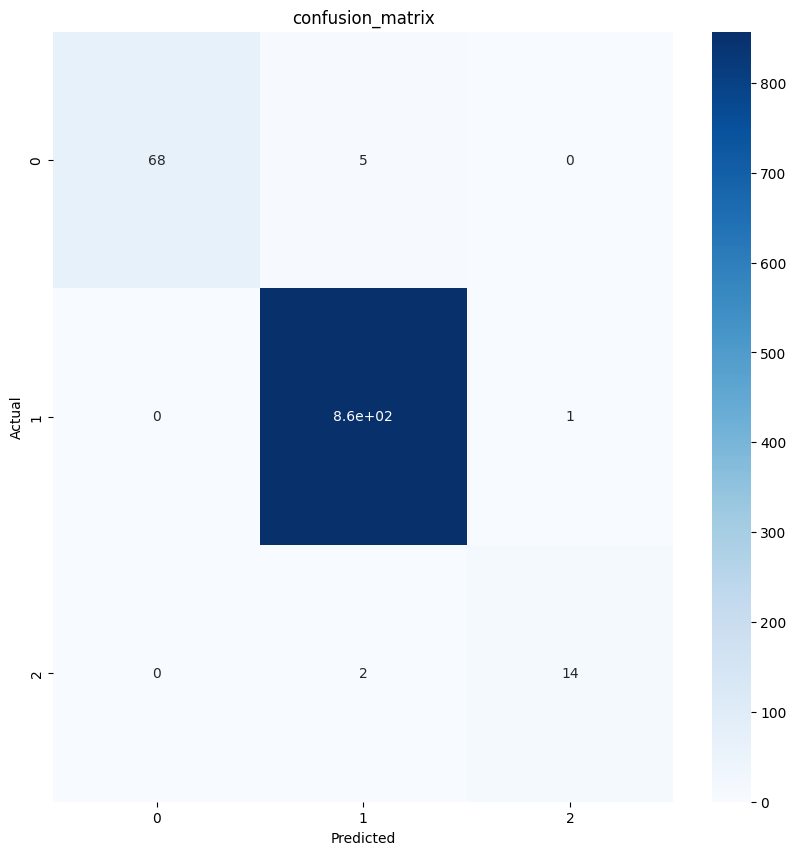

In [35]:
cf = confusion_matrix(y_test , y_test_pred )

plt.figure(figsize=(10,10))

sns.heatmap(cf , annot=True , cmap="Blues")

plt.title("confusion_matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()